# Duke Photoacoustic Imaging Lab - Soft Array Undersampling Project
## Title: Model Inference Notebook
## Author: Anthony DiSpirito III
## Github: @axd465
## Date:

### Import Statements

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import imageio.v3 as imageio
import scipy
import pandas as pd
from functools import partial

GPU = 0
GPU_MEM = 32768#32768 # in Mb
use_mixed_prec = False#True#False

physical_gpus = tf.config.list_physical_devices('GPU')

if physical_gpus:
    try:
        # Disable GPU
        if GPU is None:
            gpu_id = []
        else:
            gpu_id = physical_gpus[GPU:GPU+1]
        tf.config.set_visible_devices(gpu_id, 'GPU')
        visible_gpus = tf.config.get_visible_devices('GPU')
        print("Num Visible Physical GPUs: ", len(physical_gpus),
              "\nNum Visible GPUs Available: ", len(visible_gpus))
        if GPU is not None and GPU_MEM is not None:
            tf.config.set_logical_device_configuration(
                gpu_id[0],
                [tf.config.LogicalDeviceConfiguration(memory_limit=GPU_MEM)]
            )
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(visible_gpus), "Visible GPUs,", len(logical_gpus), "Logical GPUs")
        print(f"Visible Devices are: {tf.config.get_visible_devices()}")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

%matplotlib inline
%load_ext autoreload
%autoreload 2
MAP_AUTOTUNE = tf.data.AUTOTUNE#int(os.cpu_count()*2/3)#int(os.cpu_count()*1/3)
AUTOTUNE = tf.data.AUTOTUNE
print('Tensorflow version: ' + tf.__version__)

# For Mixed Precision
from tensorflow.keras import mixed_precision
if use_mixed_prec:
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print('Compute dtype: %s' % policy.compute_dtype)
    print('Variable dtype: %s' % policy.variable_dtype)

Num Visible Physical GPUs:  2 
Num Visible GPUs Available:  1
1 Visible GPUs, 1 Logical GPUs
Visible Devices are: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tensorflow version: 2.11.0


## Model Inference

### Load Model

In [5]:
input_dir = "saved_3d_unet_gpu0_v1"

In [2]:
# input_dir = "./saved_models_0/saved_model-epoch_77-val_loss_0.5022698045.h5"
# model =  tf.keras.models.load_model(input_dir, compile=False)

In [7]:
input_dir = os.path.join('./trained_models', input_dir)
best_model_dir = os.path.join(input_dir, 'best_models')
file_list = [file for file in os.listdir(best_model_dir) if os.path.isfile(os.path.join(best_model_dir, file))]
filename = sorted(file_list, key = lambda x : int(x.partition('h_')[2].partition('-')[0]))[-1]
path = os.path.join(best_model_dir, filename)
print('Loading Model...')
print(f'Model Path: {path}')
model = tf.keras.models.load_model(path, compile=False)
print('Done!!!')

Loading Model...
Model Path: ./trained_models/saved_3d_unet_gpu0_v1/best_models/saved_model-epoch_37-val_loss_0.5480708480.h5
Done!!!


### Use Example From Test Dataset To Show Model Inference Performance

#### Load data

In [3]:
from python.utils.vol_process_utils import import_mat

sparse_mat_dict = import_mat("./recon_code/pa_code/sparse_matrix.mat")
rfdata_dict = import_mat("./recon_code/pa_code/test_rfdata.mat")

In [4]:
sparse_mat_dict.keys()

dict_keys(['Cols', 'Rows', 'arr_size', 'data', 'interp_scale', 'mat_file_version'])

In [5]:
rfdata_dict.keys()

dict_keys(['__header__', '__version__', '__globals__', 'interp_scale', 'rfdata', 'mat_file_version'])

In [6]:
rfdata = np.array(rfdata_dict["rfdata"], dtype=np.float32)
new_size = [rfdata.shape[0]*sparse_mat_dict["interp_scale"][0, 0],
            rfdata.shape[1]*sparse_mat_dict["interp_scale"][1, 0]]
new_size = np.array(new_size, dtype=np.int32)
print(new_size)
rfdata = np.squeeze(tf.image.resize(rfdata[..., tf.newaxis], size=new_size))

[7680  256]


In [7]:
rfdata.shape

(7680, 256)

In [8]:
import cupy as cp
from cupyx.scipy.sparse import csr_matrix as csr_gpu
from cupyx.scipy.sparse import csc_matrix as csc_gpu
from scipy.sparse import csr_array, csc_array

indices = np.zeros([sparse_mat_dict["Cols"].shape[-1], 2], dtype=np.uint32)
indices[:, 0] = np.array(sparse_mat_dict["Rows"], dtype=np.uint32) - 1
indices[:, 1] = np.array(sparse_mat_dict["Cols"], dtype=np.uint32) - 1
values = np.array(sparse_mat_dict["data"], dtype=np.float16).flatten()
dense_shape = np.array(sparse_mat_dict["arr_size"], dtype=np.uint32).flatten()

In [9]:
def gpu_matmul(M_gpu, x_gpu):
    out = M_gpu.dot(x_gpu)
    return out

In [10]:
orig_rfdata = rfdata
rfdata = rfdata/np.max(np.abs(rfdata))

In [11]:
rfdata_flat = rfdata.T.flatten()[..., tf.newaxis]
x = np.array(rfdata_flat, dtype=np.float16)  #(numpy.ndarray)
print(x.shape)

(1966080, 1)


In [12]:
M = csc_array((values, (indices[:, 0], indices[:, 1])), shape=dense_shape) #(scipy.sparse.csr_matrix)
print(M.shape)

(2496688, 1966080)


#### Fully Sampled Ground Truth

In [13]:
M_gpu = csc_gpu(M)
x_gpu = cp.array(x)

In [14]:
out = gpu_matmul(M_gpu, x_gpu)
out = out.get()
print(out.shape)
out_shape = (134, 137, 136)#(134, 137, 136)
p0_recon = tf.transpose(tf.reshape(out, out_shape))
p0_recon = np.array(p0_recon, dtype=np.float32)
gt_vol = p0_recon
print(gt_vol.shape)

(2496688, 1)
(136, 137, 134)


#### Undersampled Input

In [15]:
down_ratio = 2
rfdata_down = np.zeros(rfdata.shape)
rfdata_down[:, ::down_ratio] = rfdata[:, ::down_ratio]
rfdata_flat_down = rfdata_down.T.flatten()[..., tf.newaxis]
x_down = np.array(rfdata_flat_down, dtype=np.float16)  #(numpy.ndarray)
print(x_down.shape)

(1966080, 1)


In [16]:
x_gpu = cp.array(x_down)

In [17]:
out = gpu_matmul(M_gpu, x_gpu)
out = out.get()
print(out.shape)
out_shape = (134, 137, 136)#(134, 137, 136)
p0_recon = tf.transpose(tf.reshape(out, out_shape))
p0_recon = np.array(p0_recon, dtype=np.float32)
down_vol = p0_recon
print(down_vol.shape)

(2496688, 1)
(136, 137, 134)


In [18]:
orig_gt_vol = np.squeeze(gt_vol)
orig_down_vol = np.squeeze(down_vol)

#### Inference Test

In [19]:
gt_vol = np.squeeze(gt_vol)[None, :128, :128, :128, None]
down_vol = np.squeeze(down_vol)[None, :128, :128, :128, None]
print(gt_vol.shape)
print(down_vol.shape)

(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)


In [20]:
pred_vol = model(down_vol)[0, ..., 0]
pred_vol.shape

TensorShape([128, 128, 128])

In [21]:
img_gt = np.max(np.squeeze(gt_vol), axis=1)
img_down = np.max(np.squeeze(down_vol), axis=1)
img_pred = np.max(np.squeeze(pred_vol), axis=1)

img_gt = np.rot90(img_gt, -1)
img_down = np.rot90(img_down, -1)
img_pred = np.rot90(img_pred, -1)

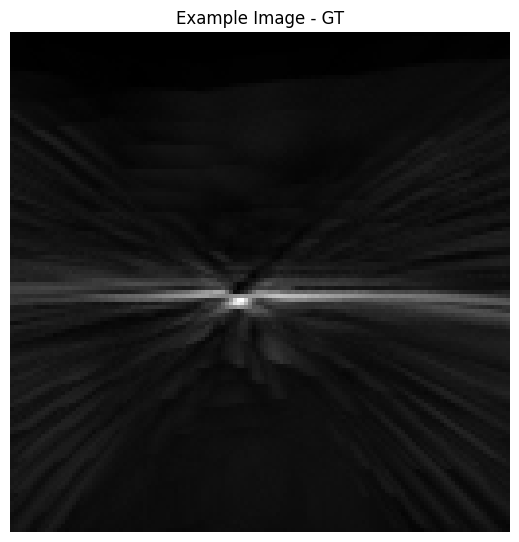

24.848286
0.012870729


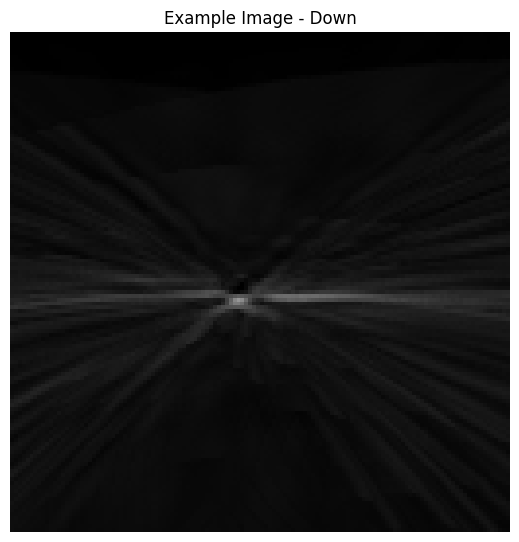

14.628691
-0.8506659


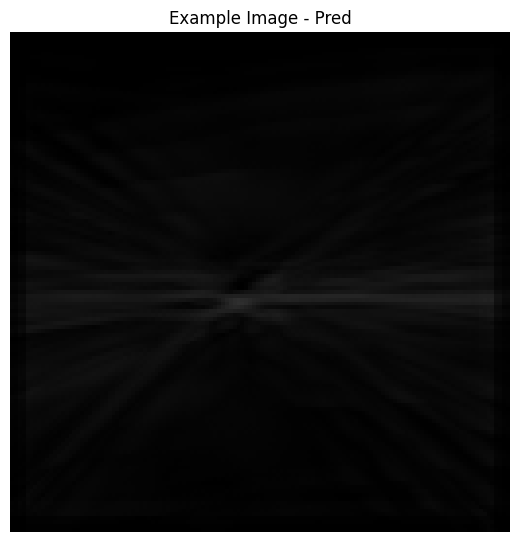

4.6094527
-0.16563496


In [22]:
max_val = np.max(img_gt)
min_val = np.min(img_gt)
figsize = (5, 5)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(img_gt, cmap='gray', clim=(min_val, max_val))
plt.title('Example Image - GT')
plt.show()
print(np.max(img_gt))
print(np.min(img_gt))

figsize = (5, 5)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(img_down, cmap='gray', clim=(min_val, max_val))
plt.title('Example Image - Down')
plt.show()
print(np.max(img_down))
print(np.min(img_down))

figsize = (5, 5)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(img_pred, cmap='gray', clim=(min_val, max_val))
plt.title('Example Image - Pred')
plt.show()
print(np.max(img_pred))
print(np.min(img_pred))

In [23]:
img_gt = np.max(np.squeeze(gt_vol), axis=0)
img_down = np.max(np.squeeze(down_vol), axis=0)
img_pred = np.max(np.squeeze(pred_vol), axis=0)

img_gt = np.rot90(img_gt, -1)
img_down = np.rot90(img_down, -1)
img_pred = np.rot90(img_pred, -1)

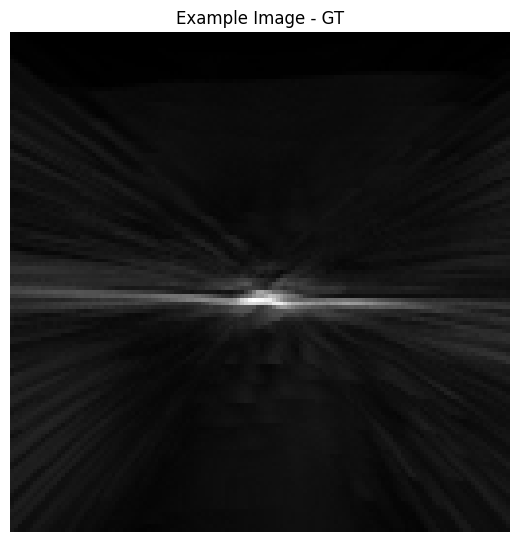

24.848286
0.02501595


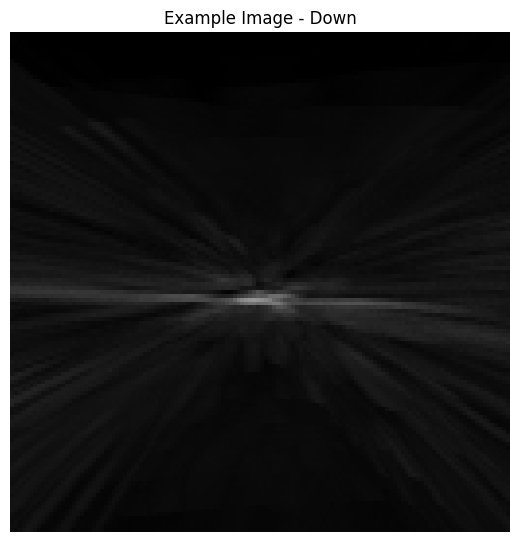

14.628691
0.0149335265


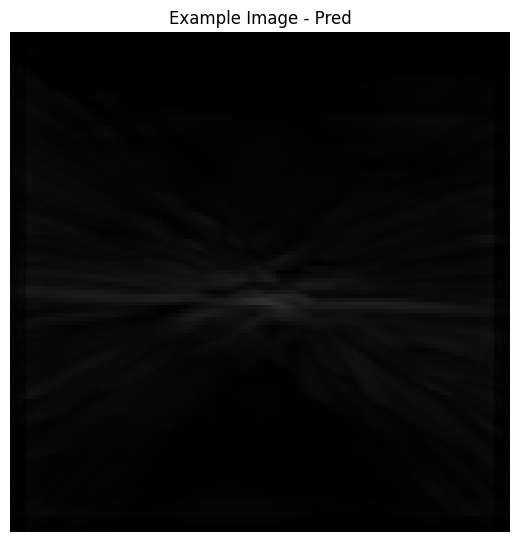

4.6094527
-0.1588652


In [24]:
max_val = np.max(img_gt)
min_val = np.min(img_gt)
figsize = (5, 5)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(img_gt, cmap='gray', clim=(min_val, max_val))
plt.title('Example Image - GT')
plt.show()
print(np.max(img_gt))
print(np.min(img_gt))

figsize = (5, 5)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(img_down, cmap='gray', clim=(min_val, max_val))
plt.title('Example Image - Down')
plt.show()
print(np.max(img_down))
print(np.min(img_down))

figsize = (5, 5)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(img_pred, cmap='gray', clim=(min_val, max_val))
plt.title('Example Image - Pred')
plt.show()
print(np.max(img_pred))
print(np.min(img_pred))

In [25]:
img_gt = np.max(np.squeeze(gt_vol), axis=2)
img_down = np.max(np.squeeze(down_vol), axis=2)
img_pred = np.max(np.squeeze(pred_vol), axis=2)

img_gt = np.rot90(img_gt, -1)
img_down = np.rot90(img_down, -1)
img_pred = np.rot90(img_pred, -1)

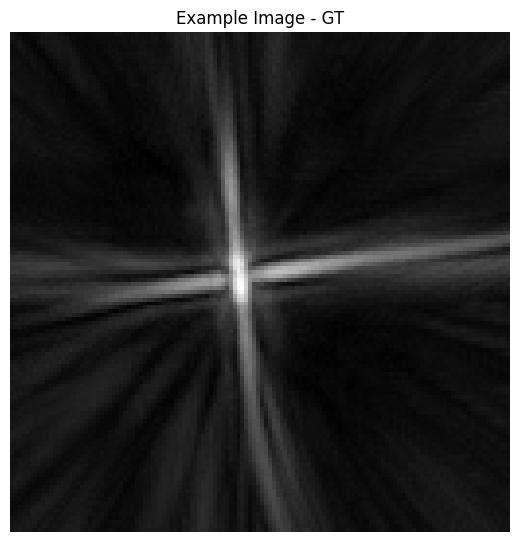

24.848286
0.79960114


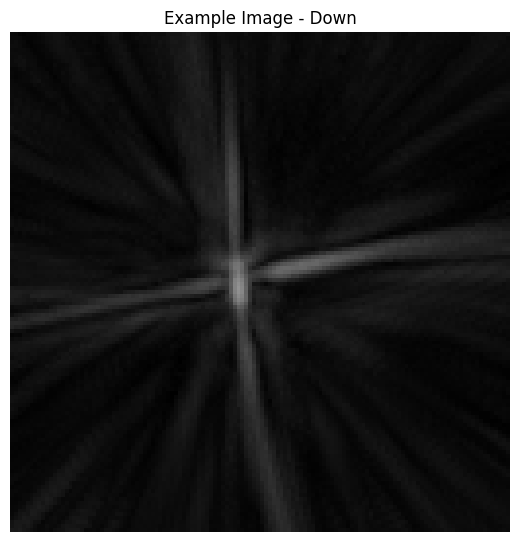

14.628691
0.7621955


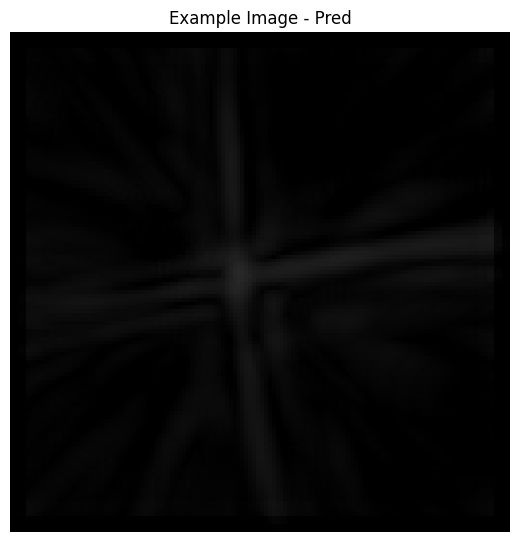

4.6094527
-0.015854595


In [26]:
max_val = np.max(img_gt)
min_val = np.min(img_gt)
figsize = (5, 5)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(img_gt, cmap='gray', clim=(min_val, max_val))
plt.title('Example Image - GT')
plt.show()
print(np.max(img_gt))
print(np.min(img_gt))

figsize = (5, 5)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(img_down, cmap='gray', clim=(min_val, max_val))
plt.title('Example Image - Down')
plt.show()
print(np.max(img_down))
print(np.min(img_down))

figsize = (5, 5)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(img_pred, cmap='gray', clim=(min_val, max_val))
plt.title('Example Image - Pred')
plt.show()
print(np.max(img_pred))
print(np.min(img_pred))